In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2

import time
from IPython.display import clear_output

## Generate Data

We are starting with a binary problem, therefore we are going to generate a binary dataset using sklearn, specifically `make_moons`. We are using `n_samples=1000` (The total number of points generated), `shuffle = True` (Whether to shuffle the samples), `noise = 0.2` (Standard deviation of Gaussian noise added to the data).

y_train shape before:  (1000,)
y_train reshaped:  (1000, 1)


(-1.321422649898922,
 1.2725498003812192,
 -1.3743430587275953,
 1.237547089775932)

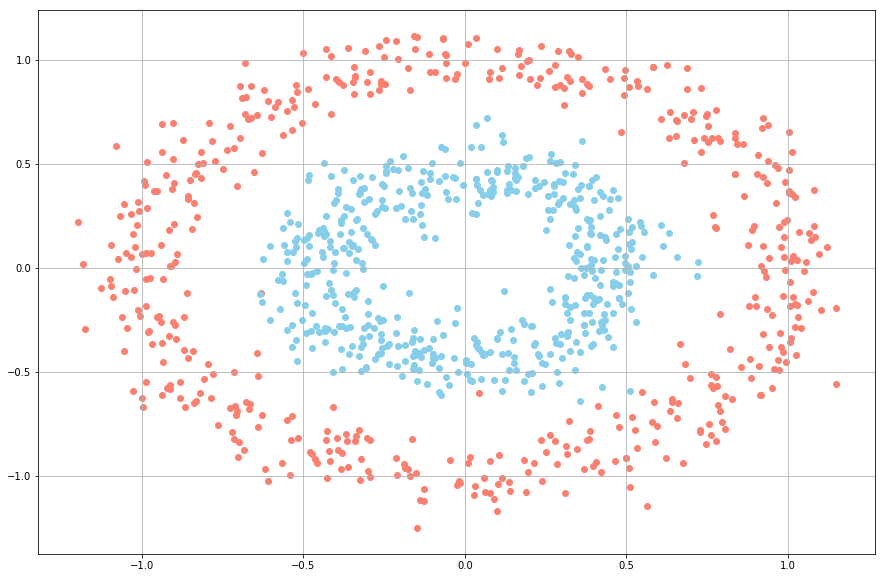

In [2]:
X_train, y = make_circles(n_samples=1000, shuffle=True, noise=0.09, factor=0.46)
# X_train, y = make_moons(n_samples=10000, shuffle=True, noise=0.08)
# X_train, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)

print('y_train shape before: ', y.shape)
# Reshape y_train -> (1000, 1)
y_train = y[:, np.newaxis]
print('y_train reshaped: ', y_train.shape)

# Plot data
plt.figure(figsize=(15,10))
plt.scatter(X_train[y == 0,0], X_train[y == 0,1], c='salmon')
plt.scatter(X_train[y == 1,0], X_train[y == 1,1], c='skyblue')
plt.grid()
plt.axis()

## Neural Network

We need to build a class to create the basic parameters of each layer. The basic unit of a neural network is called, perceptron, the perceptron is an algorithm for learning a binary classifier. So if we take a look into this, we can observe that there are 3 parameters:

<img src="imgs_note/image_1.png", width="600">

* __w__: weights
* __b__: bias
* __activation_function__: activation function to convert the value `z` to `z_act`, maps the resulting values `z` into the desired range such as between 0 to 1 or -1 to 1 etc. (depending upon the choice of activation function). 

Mathematically, we can say that the function of a perceptron is:

$f(x) = \left\{\begin{matrix}
1 & if & \vec{w}.\vec{x} + b > 0\\ 
0 & otherwise & 
\end{matrix}\right.$

So, if we combine a lot of perceptron (linear model) we will build a neural network, basically, the neural network combines linear models to create a non-linear-model for extracting non-linear patterns in the data. This is the important thing of the neural networks. 

<img src="imgs_note/image_2.png", width="600">

Now, we have understood some basic concepts, we are going to create our class called `layers` to define the basic parameters of each layer.

In [3]:
"""We need to initilizer the number of "connections" respect the last layer, the number of "neurons" and 
   the "activation function". 
   Basically, the parameters of each layer are 'b' (bias) and 'w' (weights), the bias vector 
   has the same length as the number of neurons per layer. So, we are going to initilizer the values of bias randomly

   - Bias: Vector (array / length = num_neurons). Same length as number of neurons per layer, initialized randomly but we need to 
   normalizer and standarizer these values

   - Weights: Matrix (matrix / shape = (num_connections, num_neurons)). Matrix with the 
   shape=(num_layers_previous_layer, num_neurons_actual_layer). Also, we need to normalizer and standarizer these values.
   
""" 
    
class layers():
    def __init__(self, num_connections, num_neurons, activation):
        # Initialized randomly bias and to standarizer and normalizer these values, for this reason we apply '*2 - 1'
        self.b = np.random.rand(1, num_neurons) * 2 - 1
        # Initialized randomly the matrix of weights.
        self.w = np.random.rand(num_connections, num_neurons) * 2 - 1
        
        # Activation Function
        self.activation = activation

## Activation Functions

We define 2 types of activation functions: `sigmoid` and `tanh`. There are more activations functions that we can use, but currently we are starting with these 2 types. We define also the derived of each activation functions because we are going to use it in the backpropagation process.

In [4]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.e**(-x))

# Derived function
def sigmoid_dot(x):
    return x * (1 - x)

act_func_sig = (lambda x: sigmoid(x),
            lambda x: sigmoid_dot(x))

# Tanh function
def tanh(x, derivative=False):
    if (derivative == True):
        return (1 - (x ** 2))
    return np.tanh(x)

act_func_tanh = (lambda x: tanh(x),
            lambda x: tanh(x, derivative=True))

-----------------------> SIGMOID


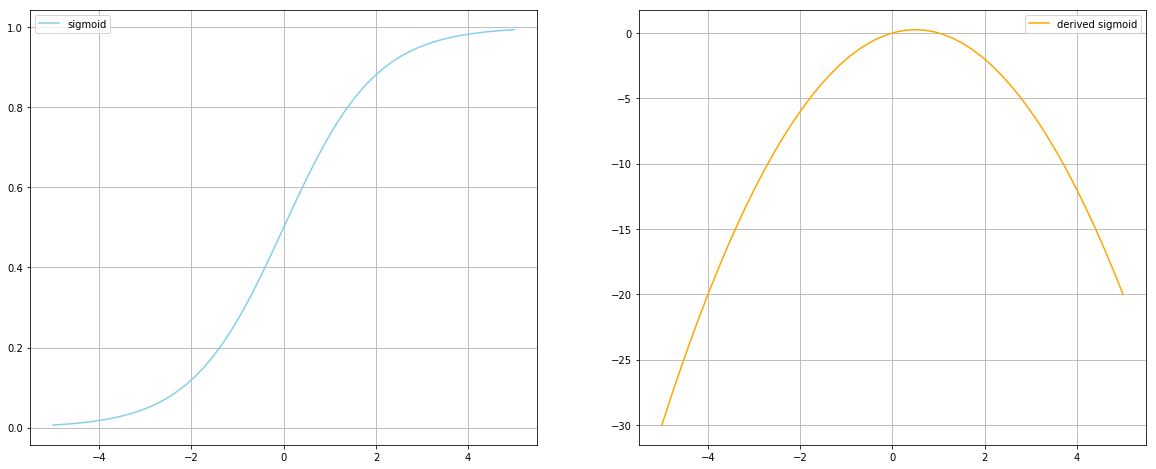

-----------------------> TANH


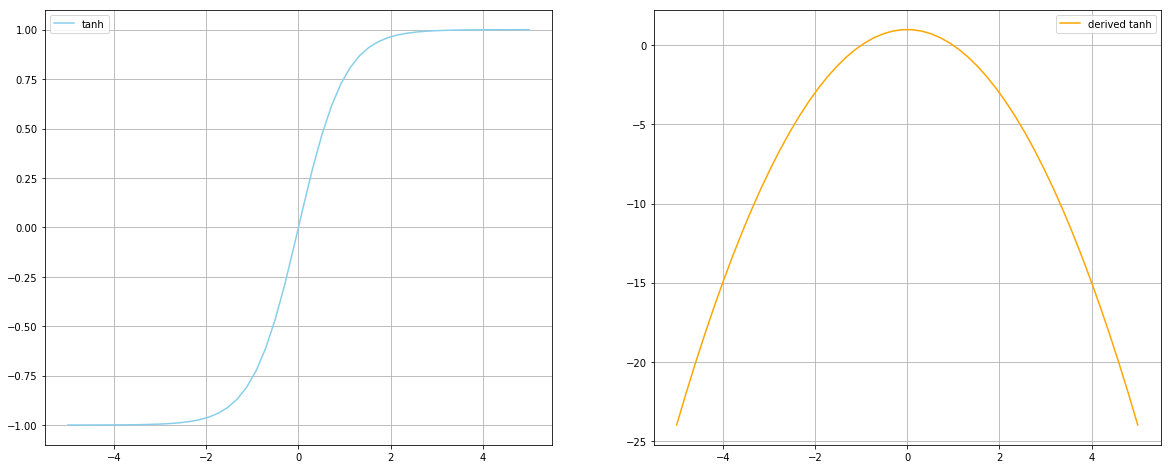

In [5]:
x_plot = np.linspace(-5,5)

f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
        
print('-----------------------> SIGMOID')
ax1.plot(x_plot, sigmoid(x_plot), label='sigmoid', color='skyblue')
ax1.grid()
ax1.legend()

ax2.plot(x_plot, sigmoid_dot(x_plot), label = 'derived sigmoid', color = 'orange')
ax2.grid()
ax2.legend()
plt.show()

print('-----------------------> TANH')
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
        
ax1.plot(x_plot, tanh(x_plot), label='tanh', color='skyblue')
ax1.grid()
ax1.legend()

ax2.plot(x_plot, tanh(x_plot, derivative = True), label = 'derived tanh', color = 'orange')
ax2.grid()
ax2.legend()
plt.show()

## Build Neural Network

Now, we have the activation functions and the basic parameters of each layer, so we can build our architecture with both of them. We only need one more thing, we have to define our architecture, we have to define how many neurons and layers we are going to have in our neural network.

For this reason, we create an array, called `num_neurons_per_layers` with the number of neurons in each layer. For instance:

`num_neurons_per_layers = [input_attrib, 8, 16, 32, 16, 8, 1]`

* __input_attrib__ = number of features in our data, we are using a binary_classify so we are 2 features.
* __hidden_layers__ = These layers are defined by : [8, 16, 32, 16, 8]
* __output_layer__ = The last layer are going to give us the prediction, as this problem is a binary problem we only have 1 neuron in this layer. 


In [6]:
# p = attributes input data

# We can define the activation function of each layer

def build_nn(num_neurons_per_layers, act_func):
  
    built_nn = []
  
    for l, layer in enumerate(num_neurons_per_layers[:-1]):
        built_nn.append(layers(num_neurons_per_layers[l], num_neurons_per_layers[l+1], act_func))
    
    return built_nn

# How this problem is a binary problem:
input_attrib = 2

num_neurons_per_layers = [input_attrib, 8, 16, 32, 16, 8, 1]

neural_nn = build_nn(num_neurons_per_layers, act_func = act_func_sig)

## Train

To train the neural network we need to define the error function, this function are going to calculate the difference between the result of the neural network `y_pred` and the real result `y_true`, we use the mean squared error. Also, we derive this function because we will use it in the backpropagation process.

In [7]:
# Mean Squared Error
def error(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

# Derivated Mean Squared Error
def error_dot(y_pred, y_true):
    return (y_pred - y_true)

error_func = (lambda y_pred, y_true: error(y_pred, y_true),
              lambda y_pred, y_true: error_dot(y_pred, y_true))

Basically, we split the training process in: 

__Forward__
We need to take each layer and calculate the equation explained above and apply the activation function to the result `z` getting `z_act`.

__Backpropagation__
In this part we start by the end of the neural network, so we apply `reversed` to start by the last layer and we have to calculate the error in the next layer respect to the actual layer. Then, we apply the gradient descent to update the weights of the neural network.

The equations for backpropagation can find here: https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html

In [8]:
def train(neural_nn, X, y, error_func, train=True):
    """Forward"""
    output = [(None, X)]
    # Go over each layer
    for l in range(len(neural_nn)):
        layer = neural_nn[l] 
        # Make this operation: z = X*w + b. So, we take the 'w' and 'b' of each layer
        # output[-1][1]: the last value in output [-1] and the activation [1]
        z = output[-1][1] @ neural_nn[l].w + neural_nn[l].b
        # Apply activation
        z_act = neural_nn[l].activation[0](z)

        # Append 'z=X*w + b' and 'z_act = activation_function(z)'
        output.append((z, z_act))
        
    " Backward "
    if train:
        deltas = []

        for l in reversed(range(0, len(neural_nn))):
            # Take the 'z' and 'z_act' values
            # l+1 because we are not going to take the input layer
            z = output[l+1][0]
            z_act = output[l+1][1]

            # In the last layer, we calculate the delta respect to the activation function
            if l == len(neural_nn) - 1:
                deltas.insert(0, error_func[1](z_act, y_train) * neural_nn[l].activation[1](z_act))
            # For the rest, we calculate the deltas on this way:
            else:
                deltas.insert(0, deltas[0] @ _W.T * neural_nn[l].activation[1](z_act))

            # New weight matrix
            _W = neural_nn[l].w

            # Calculate gradient descent
            neural_nn[l].b = neural_nn[l].b - np.mean(deltas[0], axis=0, keepdims=True) * learning_rate   
            neural_nn[l].w = neural_nn[l].w - output[l][1].T @ deltas[0] * learning_rate

    return output[-1][1]

We use a loop to train the neural network for 2000 epochs, using a learning_rate = 0.03, we are going to plot the results of the neural network using `heatmap` to see how it's changing per epoch.

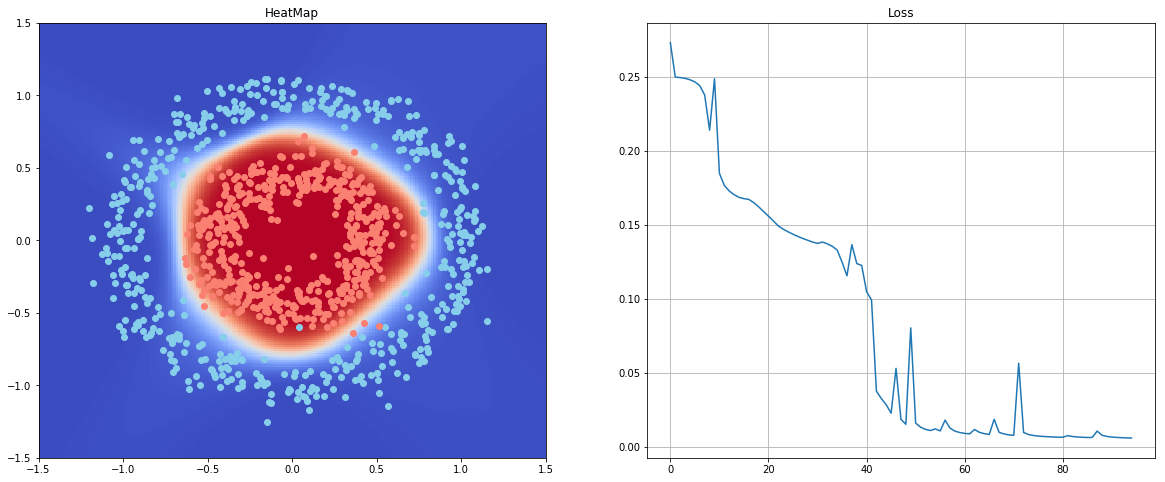

KeyboardInterrupt: 

In [16]:
input_attrib = 2
learning_rate = 0.03

# num_neurons_per_layers = [input_attrib, 8, 16, 32, 16, 8, 1]

num_neurons_per_layers = [input_attrib, 4, 6, 1]

neural_nn = build_nn(num_neurons_per_layers, act_func_sig)

loss = []

for i in range(2000):
    y_pred = train(neural_nn, X_train, y_train, error_func)
    
    epoch = i
    if i % 20 == 0:
        loss.append(error_func[0](y_pred, y_train))
        
        # Take 200 points to make predictions and to check how change our predictions each epoch
        res = 200

        x_plot = np.linspace(-1.5, 1.5, res)
        y_plot = np.linspace(-1.5, 1.5, res)

        _y_train = np.zeros((res, res))

        for i0, x0 in enumerate(x_plot):
            for i1, x1 in enumerate(y_plot):
                _y_train[i0, i1] = train(neural_nn, np.array([[x0, x1]]), y_train, error_func, train=False)[0][0]    
        
        f = plt.figure(figsize=(20,8))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        
        ax1.pcolormesh(x_plot, y_plot, _y_train, cmap="coolwarm")
        ax1.scatter(X_train[y_train[:,0] == 0, 0], X_train[y_train[:,0] == 0, 1], c="skyblue")
        ax1.scatter(X_train[y_train[:,0] == 1, 0], X_train[y_train[:,0] == 1, 1], c="salmon")
        ax1.set_title('HeatMap')

        clear_output(wait=True)
        ax2.plot(range(len(loss)), loss)
        ax2.set_title('Loss')
#         ax2.set_xlabel('Epochs')
        ax2.grid()
        plt.show()
        f.savefig('./results/to{}.png'.format(epoch))   
        
#         clear_output(wait=True)

#         plt.pcolormesh(x_plot, y_plot, _y_train, cmap="Spectral")
#         plt.axis()
#         plt.scatter(X_train[y_train[:,0] == 0, 0], X_train[y_train[:,0] == 0, 1], c="skyblue")
#         plt.scatter(X_train[y_train[:,0] == 1, 0], X_train[y_train[:,0] == 1, 1], c="salmon")
#         plt.title('HeatMap')
#         plt.show()